In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import os
import time
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install scikit-learn matplotlib seaborn
!apt-get install unrar

Looking in indexes: https://download.pytorch.org/whl/cu118
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
rar_path = '/content/drive/MyDrive/ResNet/dataset.rar'
extract_path = '/content/dataset'

print(f"Extracting {rar_path} to {extract_path}")
!unrar x "{rar_path}" /content/

Streaming output truncated to the last 5000 lines.
Extracting  /content/dataset/neutrophil/BNE_448776.jpg                    72%  OK 
Extracting  /content/dataset/neutrophil/BNE_449730.jpg                    72%  OK 
Extracting  /content/dataset/neutrophil/BNE_449915.jpg                    72%  OK 
Extracting  /content/dataset/neutrophil/BNE_450464.jpg                    72%  OK 
Extracting  /content/dataset/neutrophil/BNE_451701.jpg                    72%  OK 
Extracting  /content/dataset/neutrophil/BNE_451729.jpg                    72%  OK 
Extracting  /content/dataset/neutrophil/BNE_453088.jpg                    72%  OK 
Extracting  /content/dataset/neutrophil/BNE_454089.jpg                    72%  OK 
Extracting  /content/dataset/neutrophil/BNE_454943.jpg                    72%  OK 
Extracting  /content/dataset/neutrophil/BNE_455080.jpg                    72%  OK 
Extracting  /content/dataset/

In [5]:
if os.path.exists('/content/dataset'):
    print("✅ Dataset extracted successfully!")
    # List the contents to verify structure
    print("\nDataset contents:")
    for item in os.listdir('/content/dataset'):
        item_path = os.path.join('/content/dataset', item)
        if os.path.isdir(item_path):
            count = len(os.listdir(item_path))
            print(f"📁 {item}: {count} images")
else:
    print("❌ Extraction failed. Please check the RAR file path.")
    # Try alternative extraction location
    print("Trying alternative extraction...")
    !unrar x "/content/drive/MyDrive/ResNet/dataset.rar" /content/extracted/

✅ Dataset extracted successfully!

Dataset contents:
📁 lymphocyte: 1214 images
📁 ig: 2895 images
📁 erythroblast: 1551 images
📁 platelet: 2348 images
📁 eosinophil: 3117 images
📁 basophil: 1218 images
📁 neutrophil: 3329 images
📁 monocyte: 1420 images


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: Tesla T4


In [7]:
DATA_PATH = '/content/dataset'  # Extracted from RAR

# Verify the dataset structure
print(f"Looking for data in: {DATA_PATH}")

if os.path.exists(DATA_PATH):
    print("✅ Dataset folder found!")

    # List all subdirectories (classes)
    subdirs = [d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))]
    print(f"Found {len(subdirs)} classes: {subdirs}")

    # Update class names based on actual folder names
    CLASS_NAMES = sorted(subdirs)  # Sort to ensure consistent ordering

    # Count images in each class
    print("\nClass distribution:")
    total_images = 0
    for class_name in CLASS_NAMES:
        class_path = os.path.join(DATA_PATH, class_name)
        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
        count = len(image_files)
        total_images += count
        print(f"📁 {class_name}: {count} images")

    print(f"\n📊 Total images: {total_images}")

else:
    print("❌ Dataset folder not found!")
    print("Available folders in /content/:")
    for item in os.listdir('/content/'):
        if os.path.isdir(f'/content/{item}'):
            print(f"📁 {item}")

    # If dataset is in a subfolder, try to find it
    for root, dirs, files in os.walk('/content/'):
        for dir_name in dirs:
            if any(class_name in dir_name.lower() for class_name in ['basophil', 'eosinophil', 'lymphocyte']):
                potential_path = os.path.join(root, dir_name)
                print(f"🔍 Found potential dataset at: {potential_path}")

# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
IMG_SIZE = 224
NUM_CLASSES = len(CLASS_NAMES)

print(f"\nFinal configuration:")
print(f"📂 Data path: {DATA_PATH}")
print(f"🏷️ Classes ({NUM_CLASSES}): {CLASS_NAMES}")
print(f"🔧 Batch size: {BATCH_SIZE}, Epochs: {NUM_EPOCHS}, Learning rate: {LEARNING_RATE}")

Looking for data in: /content/dataset
✅ Dataset folder found!
Found 8 classes: ['lymphocyte', 'ig', 'erythroblast', 'platelet', 'eosinophil', 'basophil', 'neutrophil', 'monocyte']

Class distribution:
📁 basophil: 1218 images
📁 eosinophil: 3117 images
📁 erythroblast: 1551 images
📁 ig: 2895 images
📁 lymphocyte: 1214 images
📁 monocyte: 1420 images
📁 neutrophil: 3329 images
📁 platelet: 2348 images

📊 Total images: 17092

Final configuration:
📂 Data path: /content/dataset
🏷️ Classes (8): ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
🔧 Batch size: 32, Epochs: 50, Learning rate: 0.001


In [8]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

In [9]:
full_dataset = datasets.ImageFolder(root=DATA_PATH, transform=train_transform)

# Calculate class distribution
class_counts = Counter(full_dataset.targets)
total_samples = len(full_dataset)

print("Class distribution:")
for i, class_name in enumerate(CLASS_NAMES):
    count = class_counts[i]
    percentage = (count / total_samples) * 100
    print(f"{class_name}: {count} images ({percentage:.1f}%)")

# Calculate class weights for balanced training
class_weights = []
for i in range(NUM_CLASSES):
    weight = total_samples / (NUM_CLASSES * class_counts[i])
    class_weights.append(weight)

class_weights_tensor = torch.FloatTensor(class_weights).to(device)
print(f"\nClass weights: {[f'{w:.2f}' for w in class_weights]}")

Class distribution:
basophil: 1218 images (7.1%)
eosinophil: 3117 images (18.2%)
erythroblast: 1551 images (9.1%)
ig: 2895 images (16.9%)
lymphocyte: 1214 images (7.1%)
monocyte: 1420 images (8.3%)
neutrophil: 3329 images (19.5%)
platelet: 2348 images (13.7%)

Class weights: ['1.75', '0.69', '1.38', '0.74', '1.76', '1.50', '0.64', '0.91']


In [10]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Apply different transforms to validation and test sets
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Training samples: 11964
Validation samples: 2563
Test samples: 2565


In [11]:
def create_model():
    # Load pre-trained ResNet-50
    model = models.resnet50(pretrained=True)

    # Freeze early layers (optional - for faster training)
    # Uncomment to freeze first few layers
    # for param in list(model.parameters())[:-20]:
    #     param.requires_grad = False

    # Replace final layer for our number of classes
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, NUM_CLASSES)
    )

    return model

model = create_model()
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

print("Model created successfully!")
print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


Model created successfully!
Total trainable parameters: 23,524,424


In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Training phase
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            if batch_idx % 20 == 0:
                print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct_predictions / total_samples

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_acc = val_correct / val_total

        # Store metrics
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = model.state_dict().copy()

        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')
        print(f'Best Val Acc: {best_val_acc:.4f}')

        scheduler.step()

    # Load best model
    model.load_state_dict(best_model_state)

    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [13]:
print("Starting training...")
start_time = time.time()

trained_model, train_losses, train_accs, val_losses, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS
)

end_time = time.time()
print(f"\nTraining completed in {(end_time - start_time)/60:.2f} minutes")


Starting training...

Epoch 1/50
--------------------------------------------------
Batch 0/374, Loss: 2.2059
Batch 20/374, Loss: 0.6947
Batch 40/374, Loss: 1.1430
Batch 60/374, Loss: 0.6705
Batch 80/374, Loss: 0.4452
Batch 100/374, Loss: 0.3640
Batch 120/374, Loss: 0.4457
Batch 140/374, Loss: 0.1651
Batch 160/374, Loss: 0.2614
Batch 180/374, Loss: 0.2618
Batch 200/374, Loss: 0.0433
Batch 220/374, Loss: 0.9759
Batch 240/374, Loss: 0.5715
Batch 260/374, Loss: 0.2777
Batch 280/374, Loss: 0.1982
Batch 300/374, Loss: 0.5838
Batch 320/374, Loss: 0.3714
Batch 340/374, Loss: 0.1268
Batch 360/374, Loss: 0.0361
Train Loss: 0.3877, Train Acc: 0.8801
Val Loss: 0.3420, Val Acc: 0.9161
Best Val Acc: 0.9161

Epoch 2/50
--------------------------------------------------
Batch 0/374, Loss: 0.3090
Batch 20/374, Loss: 0.1008
Batch 40/374, Loss: 0.1528
Batch 60/374, Loss: 0.2290
Batch 80/374, Loss: 0.6556
Batch 100/374, Loss: 0.1329
Batch 120/374, Loss: 0.0368
Batch 140/374, Loss: 0.1925
Batch 160/374, L

In [14]:
model_save_path = '/content/drive/MyDrive/blood_cell_resnet50.pth'
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'class_names': CLASS_NAMES,
    'class_weights': class_weights,
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs
}, model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/blood_cell_resnet50.pth


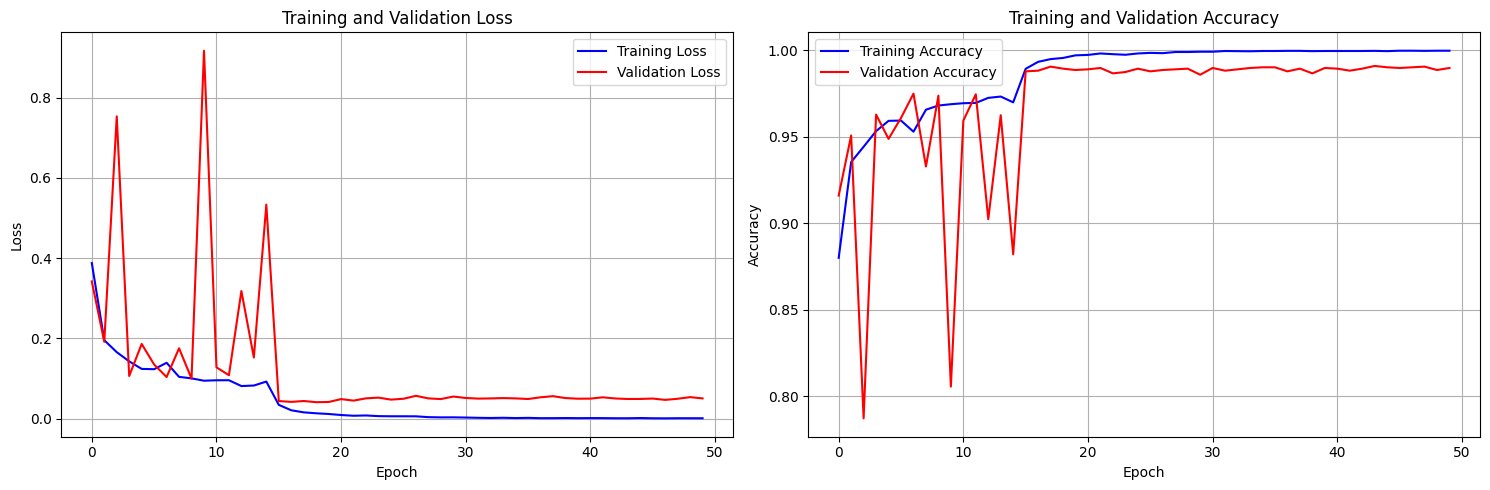

Final Training Accuracy: 0.9998
Final Validation Accuracy: 0.9899


In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Training Loss', color='blue')
ax1.plot(val_losses, label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accs, label='Training Accuracy', color='blue')
ax2.plot(val_accs, label='Validation Accuracy', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {train_accs[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accs[-1]:.4f}")

In [16]:
def evaluate_model_detailed(model, dataloader, class_names, dataset_name="Test"):
    """Detailed evaluation with per-class metrics"""
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    return all_predictions, all_labels, np.array(all_probabilities)

# Evaluate on test set
print("🧪 COMPREHENSIVE TEST SET EVALUATION")
print("=" * 60)

test_predictions, test_labels, test_probabilities = evaluate_model_detailed(
    trained_model, test_loader, CLASS_NAMES, "Test"
)

# Overall accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
overall_accuracy = accuracy_score(test_labels, test_predictions)
print(f"🎯 Overall Test Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")

# Per-class accuracy
print(f"\n📊 PER-CLASS TEST ACCURACY:")
print("-" * 50)
class_accuracies = {}
for i, class_name in enumerate(CLASS_NAMES):
    class_mask = np.array(test_labels) == i
    if np.sum(class_mask) > 0:  # If class exists in test set
        class_predictions = np.array(test_predictions)[class_mask]
        class_true_labels = np.array(test_labels)[class_mask]
        class_accuracy = accuracy_score(class_true_labels, class_predictions)
        class_accuracies[class_name] = class_accuracy

        # Count samples
        total_samples = np.sum(class_mask)
        correct_samples = np.sum(class_predictions == i)

        print(f"{class_name:15}: {class_accuracy:.4f} ({class_accuracy*100:5.2f}%) - {correct_samples}/{total_samples} samples")
    else:
        print(f"{class_name:15}: No samples in test set")


🧪 COMPREHENSIVE TEST SET EVALUATION
🎯 Overall Test Accuracy: 0.9871 (98.71%)

📊 PER-CLASS TEST ACCURACY:
--------------------------------------------------
basophil       : 0.9840 (98.40%) - 184/187 samples
eosinophil     : 0.9978 (99.78%) - 447/448 samples
erythroblast   : 0.9957 (99.57%) - 234/235 samples
ig             : 0.9765 (97.65%) - 416/426 samples
lymphocyte     : 0.9901 (99.01%) - 200/202 samples
monocyte       : 0.9817 (98.17%) - 214/218 samples
neutrophil     : 0.9767 (97.67%) - 462/473 samples
platelet       : 0.9973 (99.73%) - 375/376 samples


In [17]:
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print("=" * 80)
from sklearn.metrics import classification_report
report = classification_report(test_labels, test_predictions,
                             target_names=CLASS_NAMES,
                             digits=4)
print(report)

# Per-class precision, recall, F1-score
precision, recall, f1, support = precision_recall_fscore_support(test_labels, test_predictions)

print(f"\n📈 DETAILED PER-CLASS METRICS:")
print("-" * 80)
print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10} {'Accuracy':<10}")
print("-" * 80)
for i, class_name in enumerate(CLASS_NAMES):
    acc = class_accuracies.get(class_name, 0.0)
    print(f"{class_name:<15} {precision[i]:<10.4f} {recall[i]:<10.4f} {f1[i]:<10.4f} {support[i]:<10} {acc:<10.4f}")



📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    basophil     1.0000    0.9840    0.9919       187
  eosinophil     1.0000    0.9978    0.9989       448
erythroblast     0.9957    0.9957    0.9957       235
          ig     0.9720    0.9765    0.9742       426
  lymphocyte     0.9852    0.9901    0.9877       202
    monocyte     0.9817    0.9817    0.9817       218
  neutrophil     0.9726    0.9767    0.9747       473
    platelet     1.0000    0.9973    0.9987       376

    accuracy                         0.9871      2565
   macro avg     0.9884    0.9875    0.9879      2565
weighted avg     0.9872    0.9871    0.9872      2565


📈 DETAILED PER-CLASS METRICS:
--------------------------------------------------------------------------------
Class           Precision  Recall     F1-Score   Support    Accuracy  
--------------------------------------------------------------------------------
basophil        1.0000     0.9840     0.9919     1


🎭 CONFUSION MATRIX ANALYSIS:
Confusion matrix, without normalization


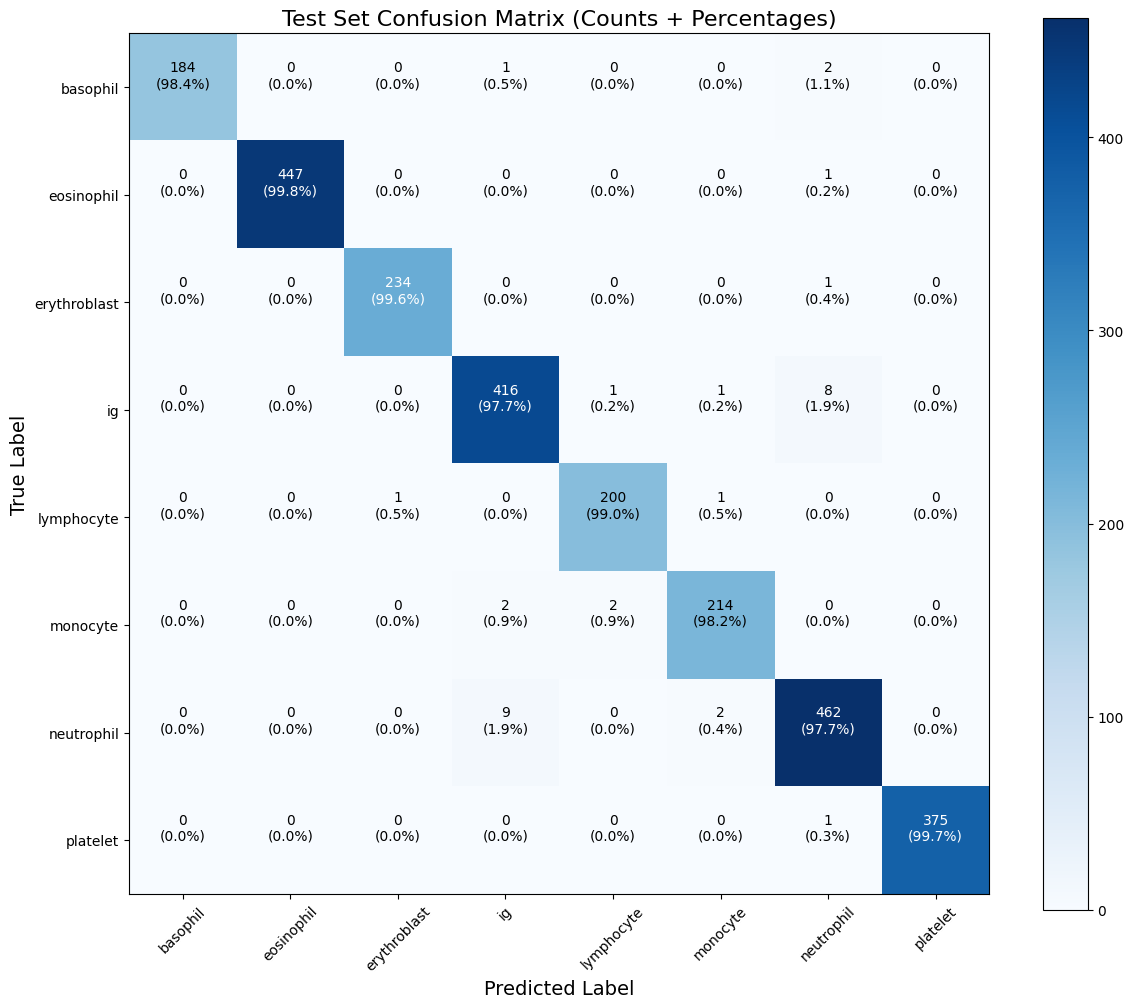

Normalized confusion matrix


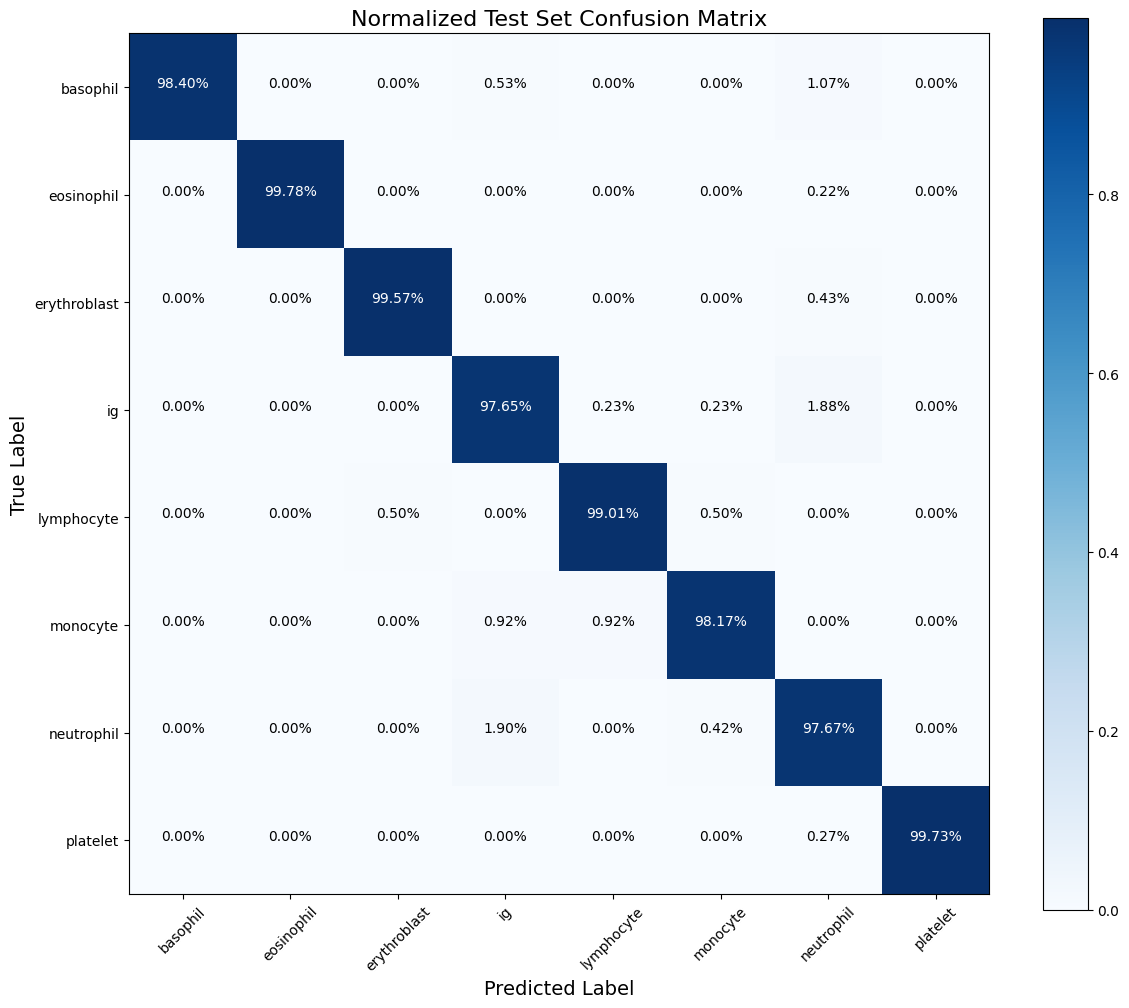

In [18]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion Matrix'):
    """Plot enhanced confusion matrix with counts and percentages"""
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
        else:
            percentage = cm[i, j] / np.sum(cm[i, :]) * 100
            plt.text(j, i, f'{cm[i, j]}\n({percentage:.1f}%)',
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.show()

# Plot confusion matrices
print(f"\n🎭 CONFUSION MATRIX ANALYSIS:")
print("=" * 60)

# Regular confusion matrix with counts and percentages
plot_confusion_matrix(test_labels, test_predictions, CLASS_NAMES,
                     title='Test Set Confusion Matrix (Counts + Percentages)')

# Normalized confusion matrix
plot_confusion_matrix(test_labels, test_predictions, CLASS_NAMES,
                     normalize=True, title='Normalized Test Set Confusion Matrix')


In [19]:
print(f"\n🔍 TOP CONFUSION ANALYSIS:")
print("=" * 60)

cm = confusion_matrix(test_labels, test_predictions)
confusion_pairs = []

for i in range(len(CLASS_NAMES)):
    for j in range(len(CLASS_NAMES)):
        if i != j and cm[i, j] > 0:
            confusion_rate = cm[i, j] / np.sum(cm[i, :])
            confusion_pairs.append((CLASS_NAMES[i], CLASS_NAMES[j], cm[i, j], confusion_rate))

# Sort by confusion rate
confusion_pairs.sort(key=lambda x: x[3], reverse=True)

print("Top 10 Most Confused Class Pairs:")
print(f"{'True Class':<15} {'Predicted As':<15} {'Count':<8} {'Error Rate':<12}")
print("-" * 60)
for true_class, pred_class, count, rate in confusion_pairs[:10]:
    print(f"{true_class:<15} {pred_class:<15} {count:<8} {rate:<12.2%}")



🔍 TOP CONFUSION ANALYSIS:
Top 10 Most Confused Class Pairs:
True Class      Predicted As    Count    Error Rate  
------------------------------------------------------------
neutrophil      ig              9        1.90%       
ig              neutrophil      8        1.88%       
basophil        neutrophil      2        1.07%       
monocyte        ig              2        0.92%       
monocyte        lymphocyte      2        0.92%       
basophil        ig              1        0.53%       
lymphocyte      erythroblast    1        0.50%       
lymphocyte      monocyte        1        0.50%       
erythroblast    neutrophil      1        0.43%       
neutrophil      monocyte        2        0.42%       



🎯 PREDICTION CONFIDENCE ANALYSIS:
Average Confidence: 0.9940
Confidence Std Dev: 0.0392
Min Confidence: 0.4836
Max Confidence: 1.0000

Correct Predictions - Avg Confidence: 0.9963
Incorrect Predictions - Avg Confidence: 0.8127


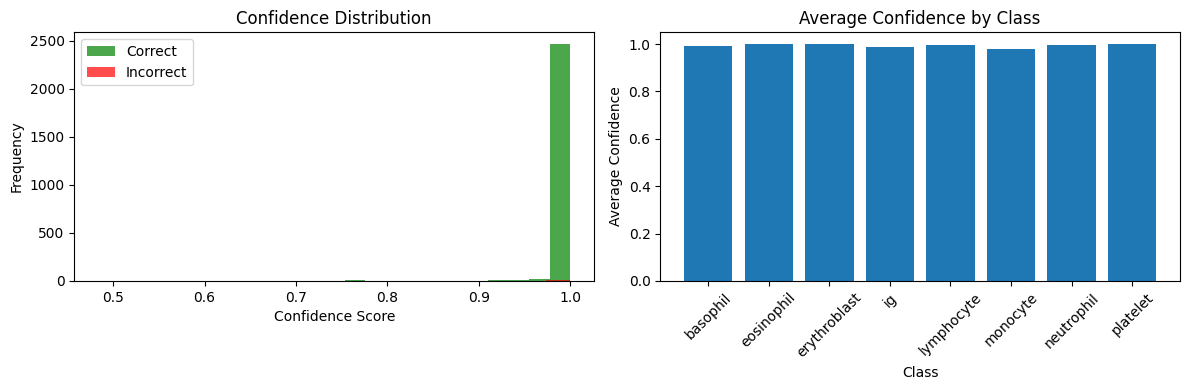

In [20]:
print(f"\n🎯 PREDICTION CONFIDENCE ANALYSIS:")
print("=" * 60)

# Calculate confidence statistics
max_probabilities = np.max(test_probabilities, axis=1)
predicted_classes = np.argmax(test_probabilities, axis=1)
correct_predictions = (predicted_classes == np.array(test_labels))

# Overall confidence stats
print(f"Average Confidence: {np.mean(max_probabilities):.4f}")
print(f"Confidence Std Dev: {np.std(max_probabilities):.4f}")
print(f"Min Confidence: {np.min(max_probabilities):.4f}")
print(f"Max Confidence: {np.max(max_probabilities):.4f}")

# Confidence by correctness
correct_confidences = max_probabilities[correct_predictions]
incorrect_confidences = max_probabilities[~correct_predictions]

print(f"\nCorrect Predictions - Avg Confidence: {np.mean(correct_confidences):.4f}")
print(f"Incorrect Predictions - Avg Confidence: {np.mean(incorrect_confidences):.4f}")

# Plot confidence distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(correct_confidences, bins=20, alpha=0.7, label='Correct', color='green')
plt.hist(incorrect_confidences, bins=20, alpha=0.7, label='Incorrect', color='red')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence Distribution')
plt.legend()

plt.subplot(1, 2, 2)
class_confidences = []
for i, class_name in enumerate(CLASS_NAMES):
    class_mask = np.array(test_labels) == i
    if np.sum(class_mask) > 0:
        class_conf = np.mean(max_probabilities[class_mask])
        class_confidences.append(class_conf)
    else:
        class_confidences.append(0)

plt.bar(range(len(CLASS_NAMES)), class_confidences)
plt.xlabel('Class')
plt.ylabel('Average Confidence')
plt.title('Average Confidence by Class')
plt.xticks(range(len(CLASS_NAMES)), CLASS_NAMES, rotation=45)

plt.tight_layout()
plt.show()

In [21]:
results_dict = {
    'model_state_dict': trained_model.state_dict(),
    'class_names': CLASS_NAMES,
    'class_weights': class_weights,
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs,
    'test_accuracy': overall_accuracy,
    'class_accuracies': class_accuracies,
    'classification_report': report,
    'confusion_matrix': cm.tolist(),
    'test_predictions': test_predictions,
    'test_labels': test_labels,
    'test_probabilities': test_probabilities.tolist()
}

# Save to Google Drive
results_save_path = '/content/drive/MyDrive/blood_cell_results.pth'
torch.save(results_dict, results_save_path)

print(f"\n💾 RESULTS SAVED:")
print(f"📁 Model and results saved to: {results_save_path}")
print(f"📊 Test Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print(f"🎯 Best Validation Accuracy: {max(val_accs):.4f}")

print(f"\n✅ EVALUATION COMPLETE!")
print("=" * 60)
print("Summary of what was generated:")
print("✓ Overall test accuracy")
print("✓ Per-class accuracy for each blood cell type")
print("✓ Precision, Recall, F1-score for each class")
print("✓ Detailed classification report")
print("✓ Confusion matrix with counts and percentages")
print("✓ Top confused class pairs analysis")
print("✓ Prediction confidence analysis")
print("✓ All results saved to Google Drive")


💾 RESULTS SAVED:
📁 Model and results saved to: /content/drive/MyDrive/blood_cell_results.pth
📊 Test Accuracy: 0.9871 (98.71%)
🎯 Best Validation Accuracy: 0.9910

✅ EVALUATION COMPLETE!
Summary of what was generated:
✓ Overall test accuracy
✓ Per-class accuracy for each blood cell type
✓ Precision, Recall, F1-score for each class
✓ Detailed classification report
✓ Confusion matrix with counts and percentages
✓ Top confused class pairs analysis
✓ Prediction confidence analysis
✓ All results saved to Google Drive
